# Logistic regression

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

from model_utils import calc_gini_coef, plot_pr_curve, plot_roc_curve

In [2]:
from model_utils import split_dataset

CLIENT_PATH = '../data/initial/CLIENTS.csv'
FEATURES_PATH = '../data/features/features_no_row_delete_inner_join.csv'

X_train, X_valid, X_test, y_train, y_valid, y_test = split_dataset(CLIENT_PATH, FEATURES_PATH, valid_size=0.2)
# X_train, X_test, y_train, y_test = split_dataset(CLIENT_PATH, FEATURES_PATH, valid_size=0.2)

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# noinspection PyTypeChecker
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced',
        n_jobs=8,
        random_state=42,
    )
)
model.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [21]:
# y_true = y_train
# y_pred_proba = model.predict_proba(X_train)[:, 1]
# y_true = y_valid
# y_pred_proba = model.predict_proba(X_valid)[:, 1]
y_true = y_test
y_pred_proba = model.predict_proba(X_test)[:, 1]

Gini Coefficient:  0.5430047159218505


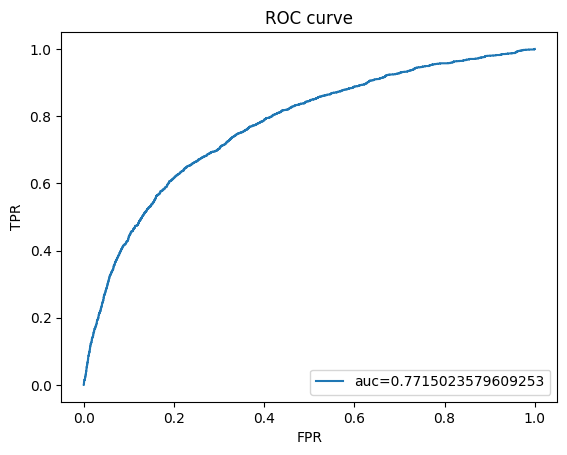

In [22]:
gini_coef = calc_gini_coef(y_true, y_pred_proba)
print('Gini Coefficient: ', gini_coef)

plot_roc_curve(y_true, y_pred_proba)

In [6]:
y_pred = (y_pred_proba >= 0.5).astype(int)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       0.88      0.72      0.79      4185
        True       0.45      0.69      0.54      1374

    accuracy                           0.71      5559
   macro avg       0.66      0.70      0.66      5559
weighted avg       0.77      0.71      0.73      5559



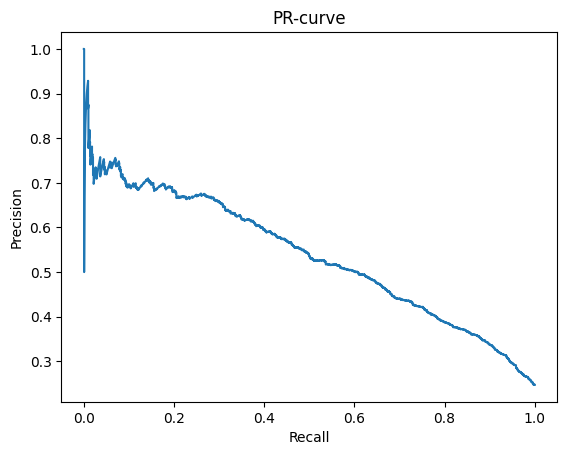

In [7]:
plot_pr_curve(y_true, y_pred_proba)

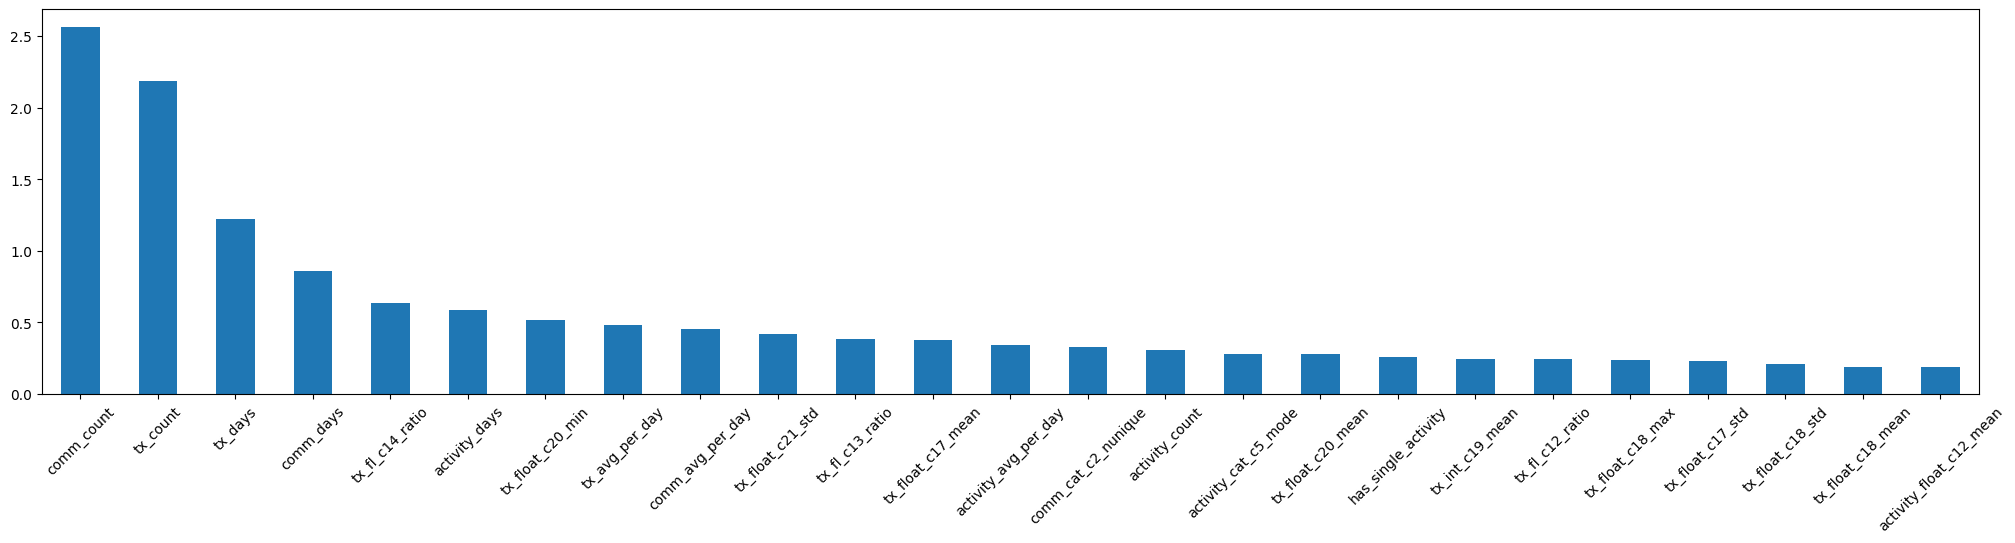

In [8]:
# Feature importance
coefs = model.named_steps['logisticregression'].coef_[0]
features_importance = pd.Series(coefs, index=X_train.columns).map(abs).sort_values(ascending=False)
features_importance.head(25).plot(kind='bar', figsize=(25, 5))
plt.xticks(rotation=45)
plt.show()